## Sentiment Anylisis Model Gift Cards
### COMP262 - Group 5
Juan Arevalo  
Jose Muniz  
Ruben Ormeno  
Samantha Ortiz de Foronda  
Mariela Ramos Vila


### 12.	Modeling (Sentiment Analysis) Machine Learning approach

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

C:\Users\maric\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#Load data
df = pd.read_json(r"C:\MR\Centennial\Sem4\NLP\Project\part b\Gift_Cards.json",lines = True)

#### Field Description
overall (bigint) – User rating (1-5)  
verified (boolean)  Is the review verified (true, false)  
reviewtime (string) – Timestamp formatted like “10 30, 2009”  
reviewerid (string) – Amazon generated user id  
asin (string) – Unique Amazon generated product id  
reviewername (string) – User supplied name  
reviewtext (string) – Review text  
summary (string) – Summary of Review text  
unixreviewtime (bigint) – Timestamp formatted in epoch time  
vote (double) – Userful voters form other users  
style - a disctionary of the product metadata, e.g., "Format" is "Hardcover"  
image -  images that users post after they have received the product  

In [3]:
# Base exploration
print('\n---Name and Types of colums---\n')
print(df.info())
print('\n---Shape----\n')
print(df.shape)



---Name and Types of colums---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147194 entries, 0 to 147193
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         147194 non-null  int64 
 1   vote            6341 non-null    object
 2   verified        147194 non-null  bool  
 3   reviewTime      147194 non-null  object
 4   reviewerID      147194 non-null  object
 5   asin            147194 non-null  object
 6   style           42375 non-null   object
 7   reviewerName    147190 non-null  object
 8   reviewText      147035 non-null  object
 9   summary         147154 non-null  object
 10  unixReviewTime  147194 non-null  int64 
 11  image           406 non-null     object
dtypes: bool(1), int64(2), object(9)
memory usage: 12.5+ MB
None

---Shape----

(147194, 12)


### a.	Select a subset of the original data minimum 2000 reviews

In [4]:
# Select a Subset of Data
subset_data = df.sample(n=2000, random_state=42)

### b. Carry out data exploration on the subset and pre-processing 

### b.1 Data exploration

In [5]:
# Base exploration
print('\n---Name and Types of colums---\n')
print(subset_data.info())
print('\n---Shape----\n')
print(subset_data.shape)


---Name and Types of colums---

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 83758 to 39037
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   overall         2000 non-null   int64 
 1   vote            96 non-null     object
 2   verified        2000 non-null   bool  
 3   reviewTime      2000 non-null   object
 4   reviewerID      2000 non-null   object
 5   asin            2000 non-null   object
 6   style           581 non-null    object
 7   reviewerName    1999 non-null   object
 8   reviewText      1998 non-null   object
 9   summary         2000 non-null   object
 10  unixReviewTime  2000 non-null   int64 
 11  image           7 non-null      object
dtypes: bool(1), int64(2), object(9)
memory usage: 189.5+ KB
None

---Shape----

(2000, 12)


In [6]:
# classes by variable
def check_columns(dataframe):
    total_counts = []
    unique_counts = []
    missing_values = []
    for column in dataframe.columns:
        try:
            # Attempt to count unique values in the usual way
            total_count = dataframe[column].count()
            unique_count = dataframe[column].nunique()
            missing_value = dataframe[column].isna().sum()
            
        except TypeError:
            # Handle unhashable items by converting them to strings (or another approach as needed)
            total_count = dataframe[column].astype(str).count()
            unique_count = dataframe[column].astype(str).nunique()
            missing_value = dataframe[column].astype(str).isna().sum() 
                
        total_counts.append(total_count)
        unique_counts.append(unique_count)
        missing_values.append(missing_value)

    # Create DataFrame with counts
    nunique_df = pd.DataFrame({'Column': dataframe.columns, 'Total counts': total_counts,'Unique Value': unique_counts, 'Missing values': missing_values})
    nunique_df = nunique_df.sort_values('Unique Value', ascending=False).reset_index(drop=True)
    return nunique_df
check_columns(subset_data)

,Column,Total counts,Unique Value,Missing values
0,reviewerID,2000,1993,0
1,reviewText,1998,1899,2
2,reviewerName,1999,1765,1
3,reviewTime,2000,1194,0
4,unixReviewTime,2000,1194,0
5,summary,2000,1092,0
6,asin,2000,488,0
7,vote,96,23,1904
8,style,2000,21,0
9,image,2000,8,0



Counts and Averages of Overall:
count    2000.000000
mean        4.648000
std         0.994279
min         1.000000
25%         5.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: overall, dtype: float64


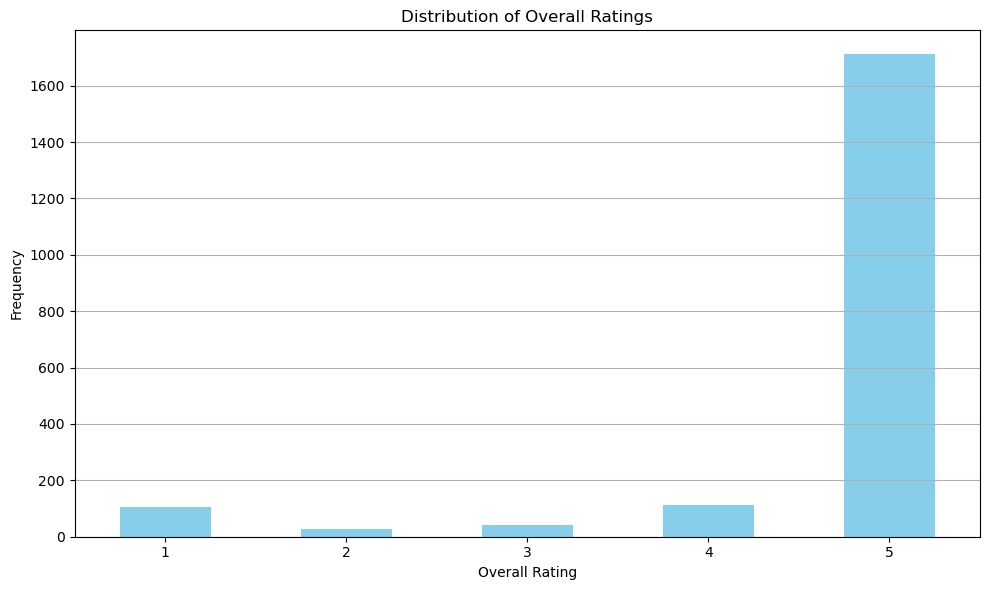

In [7]:
# Select numerical variables

# Print summary statistics
print("\nCounts and Averages of Overall:")
print(subset_data['overall'].describe())

# Plotting
plt.figure(figsize=(10, 6))
subset_data['overall'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Overall Ratings')
plt.xlabel('Overall Rating')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.grid(axis='y')  

plt.tight_layout()
plt.show()


#### Distribution of number of reviews across products

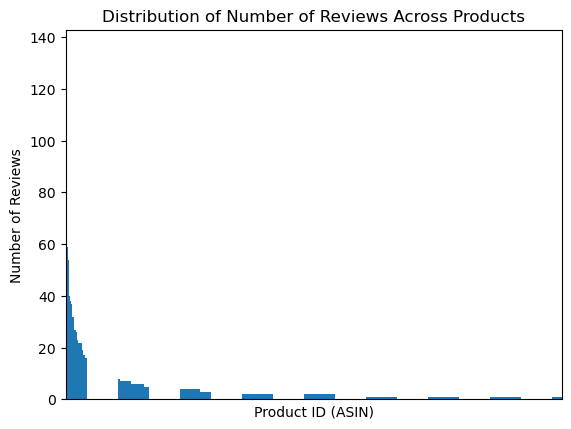

Maximum review count: 136


In [8]:
# Calculate the number of reviews per product (ASIN)
review_counts = subset_data['asin'].value_counts()

# Create the plot
#plt.figure(figsize=(10, 4))
review_counts.plot(kind='bar')
plt.title('Distribution of Number of Reviews Across Products')
plt.xlabel('Product ID (ASIN)')
plt.ylabel('Number of Reviews')
plt.xticks([])  # Rotate the x-axis labels for better readability
plt.show()

review_counts = subset_data['asin'].value_counts()
max_review_count = review_counts.max()

print("Maximum review count:", max_review_count)


#### Distribution of number of reviews per products

C:\Users\maric\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


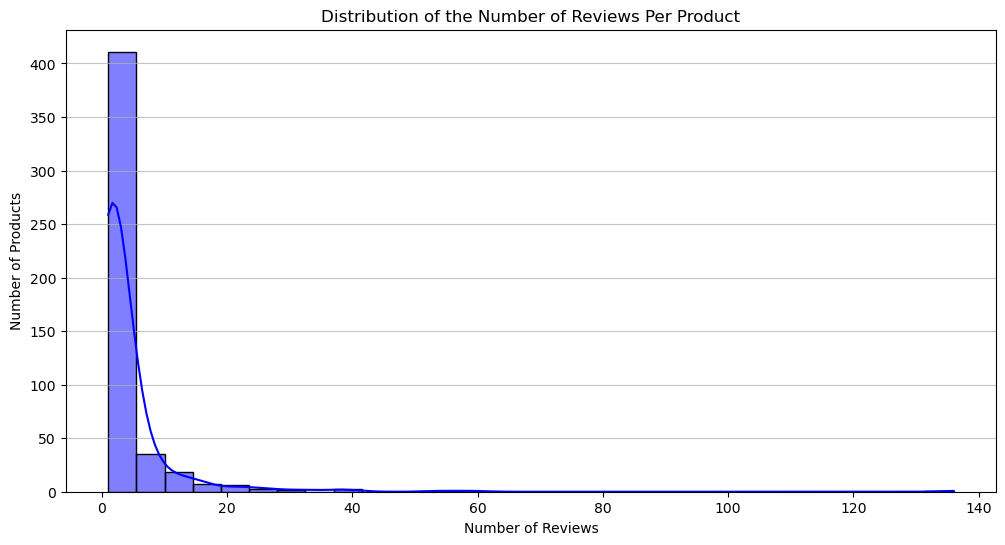

In [9]:
reviews_per_product = subset_data['asin'].value_counts()

# plot using seaborn
plt.figure(figsize=(12, 6))
sns.histplot(reviews_per_product, bins=30, kde=True, color='blue')
plt.title('Distribution of the Number of Reviews Per Product')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Products')
plt.grid(axis='y', alpha=0.75)

plt.show()


In [10]:
# Calculate the top 10 products with the most reviews and their counts
top_10_most_reviews = subset_data['asin'].value_counts().head(10)

print("Top 10 products with the most reviews:")
print(top_10_most_reviews)


Top 10 products with the most reviews:
asin
B004Q7CK9M    136
B004LLIKVU     59
B0091JKVU0     54
B0066AZGD4     40
B014S24DAI     38
B007V6ETDK     37
B00G4IV2VI     32
B0091JKY0M     32
B004LLIKY2     27
B00JDQJZWG     27
Name: count, dtype: int64


In [11]:
max_asin = top_10_most_reviews.index[0]  # maximum review count product
max_asin_reviews = subset_data[subset_data['asin'] == max_asin]['reviewText']

print("Reviews for product with ASIN", max_asin, ":", max_asin_reviews)

Reviews for product with ASIN B004Q7CK9M : 25749    I bought this as a Christmas gift because I'm ...
24762                           was a gift, very happy....
30167    I find Amazon gift cards to be the best gift c...
30986    Amazon gift cards are great to give and receiv...
24540    Gift card comes in a good quality Christmas ca...
                               ...                        
29240    Its a gift card in a nice holiday card. What e...
24210    Unfortunately, my $50 gift ended up with an in...
29620    So I figured i'd share the joy for Christmas!!...
24301                                             Awesome!
30602    My family plays "dirty santa" each year with g...
Name: reviewText, Length: 136, dtype: object


#### Distribution reviews per user

In [12]:
# Calculate the number of reviews per user
reviews_per_user = subset_data['reviewerID'].value_counts()

# Calculate the maximum, minimum, and average number of reviews per user
max_reviews_per_user = reviews_per_user.max()
min_reviews_per_user = reviews_per_user.min()
avg_reviews_per_user = reviews_per_user.mean()

print("Maximum number of reviews per user:", max_reviews_per_user)
print("Minimum number of reviews per user:", min_reviews_per_user)
print("Average number of reviews per user:", avg_reviews_per_user)


Maximum number of reviews per user: 2
Minimum number of reviews per user: 1
Average number of reviews per user: 1.0035122930255895


#### Review lengths

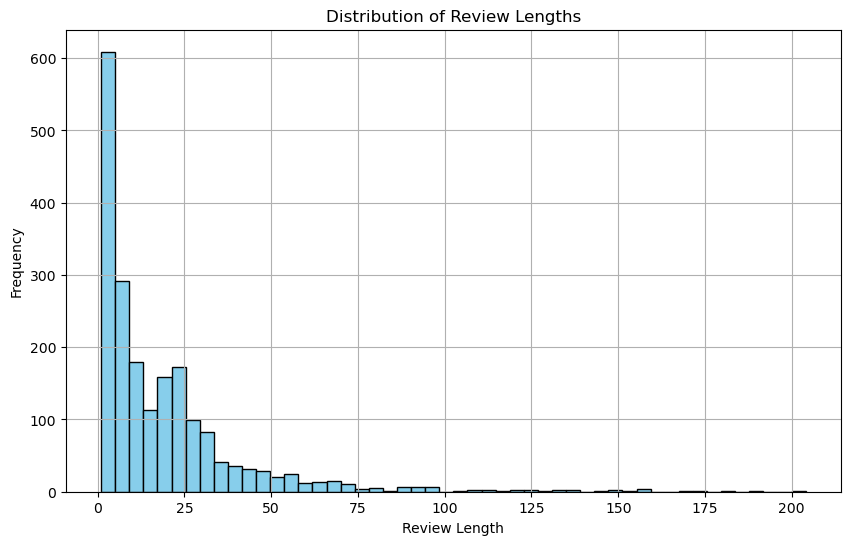

In [13]:
# Calculate review lengths
df_length = subset_data['reviewText'].dropna().apply(lambda x: len(str(x).split()))

# Plot histogram of review lengths
plt.figure(figsize=(10, 6))
plt.hist(df_length, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
# Calculate maximum, minimum, and average review lengths
max_review_length = df_length.max()
min_review_length = df_length.min()
avg_review_length = df_length.mean()


In [14]:
# review lengths
print("Minimum review length:", df_length.min())
print("Maximum review length:", df_length.max())
print("Average review length:", df_length.mean())

Minimum review length: 1
Maximum review length: 204
Average review length: 19.12112112112112


### b.2 Pre-processing

In [15]:
# Labeling the data based on ratings
def label_rating(row):
    if row['overall'] >= 4:
        return 'positive'
    elif row['overall'] == 3:
        return 'neutral'
    else:  # Ratings 1 and 2
        return 'negative'

subset_data['rating_label'] = subset_data.apply(label_rating, axis=1)

#### Chose the appropriate columns for your sentiment analyzer

In [16]:
# Dropping columns 'image', 'vote', and 'style' columns because are not important for the analysis
subset_data.drop(columns=['image', 'vote', 'style'], inplace=True, errors='ignore')


# Dropping 'overall' because'rating_label' will be used
subset_data.drop(columns=['overall'], inplace=True)

# Dropping columns that are not important for Sentiment analysis
subset_data.drop(columns=['reviewerName', 'reviewerID', 'asin', 'unixReviewTime', 'reviewTime' ], inplace=True)

# Chose the appropriate columns for your sentiment analyzer
subset_data['reviewText'] = subset_data['reviewText'].fillna('')
subset_data['summary'] = subset_data['summary'].fillna('')

# Combine 'reviewText' and 'summary' into a single column for a comprehensive sentiment analysis
subset_data['combined_text'] = subset_data['reviewText'] + " " + subset_data['summary']

subset_data.drop(columns=['reviewText', 'summary'], inplace=True, errors='ignore')

# Print the shape of the DataFrame to see the number of entries and columns
print("DataFrame shape:", subset_data.shape)

subset_data.head()

DataFrame shape: (2000, 3)


,verified,rating_label,combined_text
83758,True,neutral,Not much to really say about this other than i...
135602,True,positive,Ok Five Stars
65221,True,positive,Good Five Stars
39765,True,positive,The gift card was printed on line and we found...
2495,True,positive,I very much like the print-at-home Amazon gift...


In [17]:
# Print a summary of any missing values in the combined_text column
print("\nMissing values in 'combined_text':", subset_data['combined_text'].isnull().sum())



Missing values in 'combined_text': 0


#### Check for outliers

#### Unverified Reviewers outliers

In [18]:
def identify_unverified_reviewers(df):
    unverified_reviewers = df[df['verified'] == False]
    df = df.drop(unverified_reviewers.index)
    return len(unverified_reviewers)


unverified_reviewers_count = identify_unverified_reviewers(subset_data)
print("Number of Unverified Reviewers:", unverified_reviewers_count)


Number of Unverified Reviewers: 128


In [19]:
# Delete unverified users reviews 
subset_data = subset_data[subset_data['verified'] != False]
subset_data.shape


(1872, 3)

In [20]:
# Drop column 'verified'
subset_data.drop(columns=['verified'], inplace=True, errors='ignore')
subset_data.shape

(1872, 2)

#### Word count outliers

Outlier threshold (Z-Score Method): 89.50687277278811


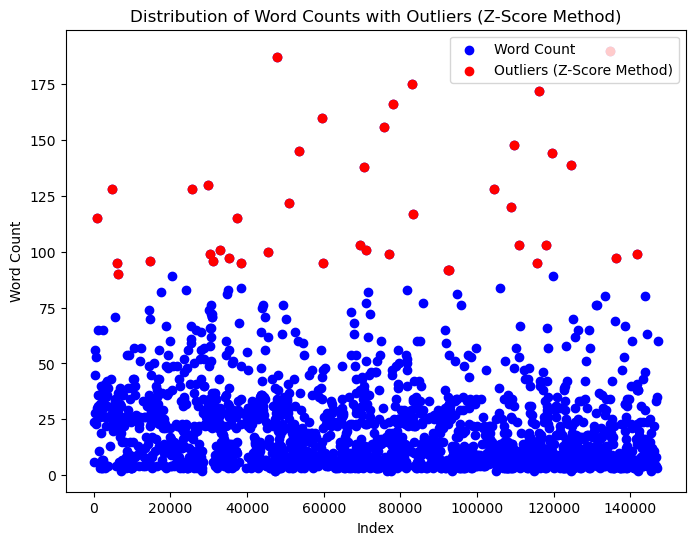

In [21]:
# Check for outliers in 'combined_text' by word count
subset_data['word_count'] = subset_data['combined_text'].fillna('').apply(lambda x: len(x.split()))

# Calculate z-scores
mean_length = subset_data['word_count'].mean()
std_length = subset_data['word_count'].std()

# Define threshold for outliers using z-scores
z_score_threshold = 3

# Print outlier threshold
outlier_threshold = mean_length + z_score_threshold * std_length
print("Outlier threshold (Z-Score Method):", outlier_threshold)

# Calculate z-scores for word count
wordcount_z_score = (subset_data['word_count'] - mean_length) / std_length

# Identify outliers using z-scores
outliers_z_score = subset_data['word_count'][(wordcount_z_score > z_score_threshold) | (wordcount_z_score < -z_score_threshold)]

# Create a scatter plot to visualize the distribution of review lengths and identify outliers using z-scores
plt.figure(figsize=(8, 6))
plt.scatter(subset_data['word_count'].index, subset_data['word_count'], c='blue', label='Word Count')
plt.scatter(outliers_z_score.index, outliers_z_score, c='red', label='Outliers (Z-Score Method)')
plt.xlabel('Index')
plt.ylabel('Word Count')
plt.title('Distribution of Word Counts with Outliers (Z-Score Method)')
plt.legend()
plt.show()

In [22]:
# Filter rows where word count is less than or equal to 89 to delete oouliers
subset_data = subset_data[subset_data['word_count'] <= outlier_threshold]

# Drop the 'word_count' column as it's no longer needed
subset_data.drop(columns=['word_count'], inplace=True)

# Optionally, you can reset the index of the DataFrame after dropping rows
subset_data.reset_index(drop=True, inplace=True)

subset_data.shape

(1831, 2)

In [23]:
subset_data.head()

,rating_label,combined_text
0,neutral,Not much to really say about this other than i...
1,positive,Ok Five Stars
2,positive,Good Five Stars
3,positive,The gift card was printed on line and we found...
4,positive,I very much like the print-at-home Amazon gift...


In [24]:
subset_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1831 entries, 0 to 1830
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   rating_label   1831 non-null   object
 1   combined_text  1831 non-null   object
dtypes: object(2)
memory usage: 28.7+ KB


#### Duplicates

In [25]:
# Find duplicates in the 'combined_text' column
duplicates_combinedText = subset_data[subset_data.duplicated(subset=['combined_text'], keep=False)]

# Count the number of duplicate rows based on specific columns
duplicate_count = duplicates_combinedText.shape[0]

print("Number of duplicate rows considering reviewerID, asin, unixReviewTime and reviewText:", duplicate_count)


Number of duplicate rows considering reviewerID, asin, unixReviewTime and reviewText: 98


In [26]:
# Remove duplicates from subset_data based on the 'combined_text' column
subset_data = subset_data.drop_duplicates(subset=['combined_text'], keep='first')

# Verify the removal of duplicates
print("Number of rows after removing duplicates:", len(subset_data))


Number of rows after removing duplicates: 1763


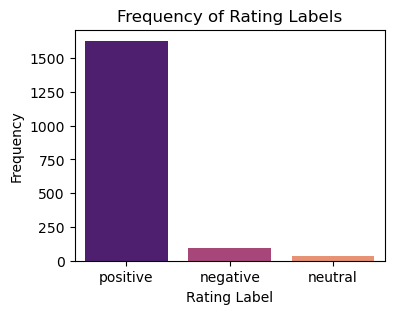

positive: 92.46%
negative: 5.39%
neutral: 2.16%
Shape of dataframe: (1763, 2)


In [27]:
# Count the frequency of each rating label
label_counts = subset_data['rating_label'].value_counts()

# Calculate percentage of each rating label
label_percentage = label_counts / len(subset_data) * 100

# Plot the frequency of each rating label using seaborn
plt.figure(figsize=(4, 3))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='magma')
plt.title('Frequency of Rating Labels')
plt.xlabel('Rating Label')
plt.ylabel('Frequency')

plt.show()


# Print the percentage for each rating label
for label, percentage in zip(label_percentage.index, label_percentage.values):
    print(f"{label}: {percentage:.2f}%")
# Print shape of dataframe
print("Shape of dataframe:", subset_data.shape)


In [28]:
# Load spaCy model for tokenization
nlp = spacy.load('en_core_web_sm')

# Define the list of stopwords and create the lemmatizer object
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Tokenize the text using spaCy
    doc = nlp(text)
    tokens = [token.text for token in doc]

    # Remove stopwords
    tokens = [token for token in tokens if token.lower() not in stop_words]

    # Lemmatize each word
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join tokens back into text
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text


subset_data['reviews_after_preprocessing'] = subset_data['combined_text'].apply(preprocess_text)
subset_data['reviews_after_preprocessing'].head()

0    much really say gift card dad Fathers Day gift...
1                                        Ok Five Stars
2                                      Good Five Stars
3    gift card printed line found process easy use ...
4    much like print - - home Amazon gift card .   ...
Name: reviews_after_preprocessing, dtype: object

### c. Split the data into 70% for training and 30% for testing,—Use stratified splitting based on the rating value field.

In [29]:
X = subset_data['reviews_after_preprocessing']

y = subset_data['rating_label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1234,) (1234,)
(529,) (529,)


### d.	Represent the text using one of the text represtations discussed in the course, make sure to note in your report why you chose that representation.

In [30]:
# Text representation using TF-IDF
tfidf_vectorizer = TfidfVectorizer()  
X_train_textr = tfidf_vectorizer.fit_transform(X_train)
X_test_textr = tfidf_vectorizer.transform(X_test)

### e.	Build two sentiment analysis models using 70% of the data. Choose two of the following Machine Learning algorithms to build and fine tune your models:

#### Logistic Regression 

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Build and fine-tune sentiment analysis models
# Model 1: Logistic Regression
logreg = LogisticRegression(class_weight="balanced") #instantiate a logistic regression model
logreg.fit(X_train_textr, y_train) #fit the model with training data

#Make predictions on test data
y_pred_class = logreg.predict(X_test_textr)



In [32]:
#Step 4: Evaluate the classifier using various measures

# Function to plot confusion matrix. 
# Ref:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import numpy as np
import itertools
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)





Accuracy:  0.9338374291115312
AUC:  0.9370470688273894
Classification Report:
              precision    recall  f1-score   support

    negative       0.54      0.64      0.58        33
     neutral       0.50      0.22      0.31         9
    positive       0.97      0.97      0.97       487

    accuracy                           0.93       529
   macro avg       0.67      0.61      0.62       529
weighted avg       0.93      0.93      0.93       529



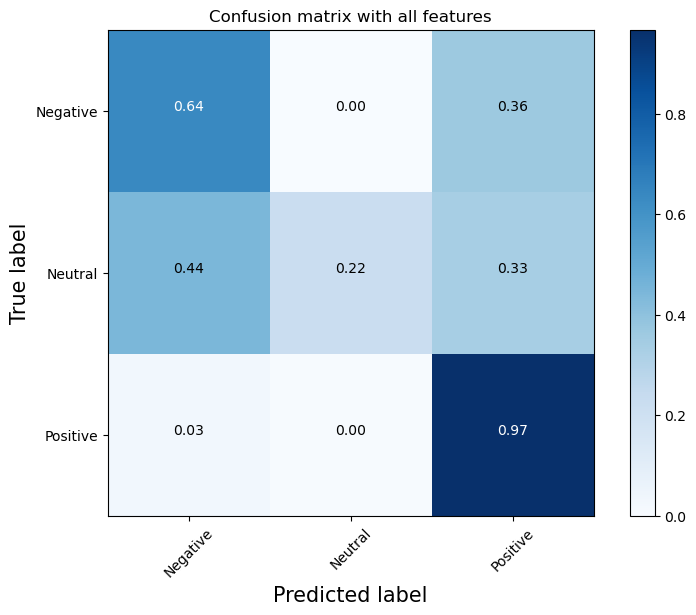

In [33]:
y_pred_prob = logreg.predict_proba(X_test_textr)

#calculate evaluation measuresfor Logistic Regression
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob, multi_class='ovr'))
# Other metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_class))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))

plot_confusion_matrix(cnf_matrix, classes=['Negative','Neutral', 'Positive'],normalize=True,
                      title='Confusion matrix with all features')

#### Support Vector Machine (SVM):

Accuracy:  0.9357277882797732
AUC:  0.9419085985845937
Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.24      0.38        33
     neutral       1.00      0.11      0.20         9
    positive       0.94      1.00      0.97       487

    accuracy                           0.94       529
   macro avg       0.94      0.45      0.52       529
weighted avg       0.93      0.94      0.92       529



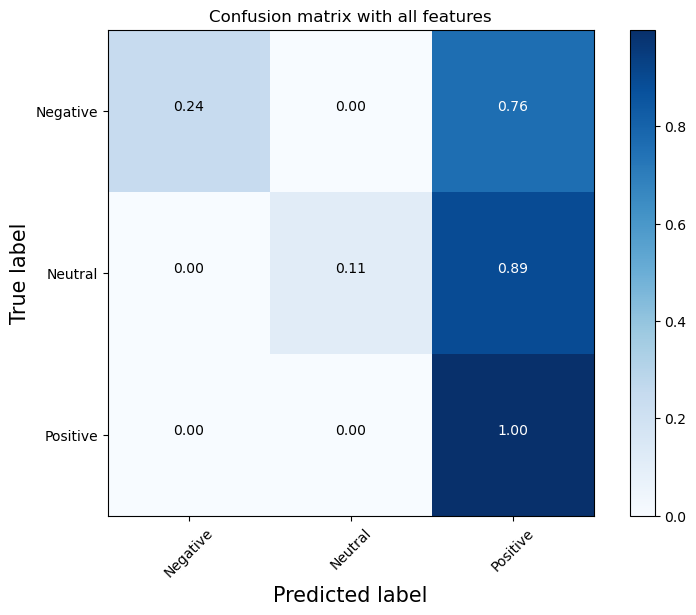

In [34]:
from sklearn.svm import SVC

# Instantiate the SVM model with 'rbf' kernel and class_weight='balanced'
svm = SVC(kernel='rbf', class_weight='balanced', probability=True)

# Fit the model with training data
svm.fit(X_train_textr, y_train)

# Make predictions on test data
y_pred_class = svm.predict(X_test_textr)

# Obtain predicted probabilities for each class
y_pred_prob = svm.predict_proba(X_test_textr)

# Calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob, multi_class='ovr'))

# Other metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_class))

# Plot confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Negative','Neutral', 'Positive'],normalize=True,
                      title='Confusion matrix with all features')

#### Naive Bayes:

Accuracy:  0.9206049149338374
AUC:  0.8813717559196794
Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        33
     neutral       0.00      0.00      0.00         9
    positive       0.92      1.00      0.96       487

    accuracy                           0.92       529
   macro avg       0.31      0.33      0.32       529
weighted avg       0.85      0.92      0.88       529



C:\Users\maric\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\maric\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\maric\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


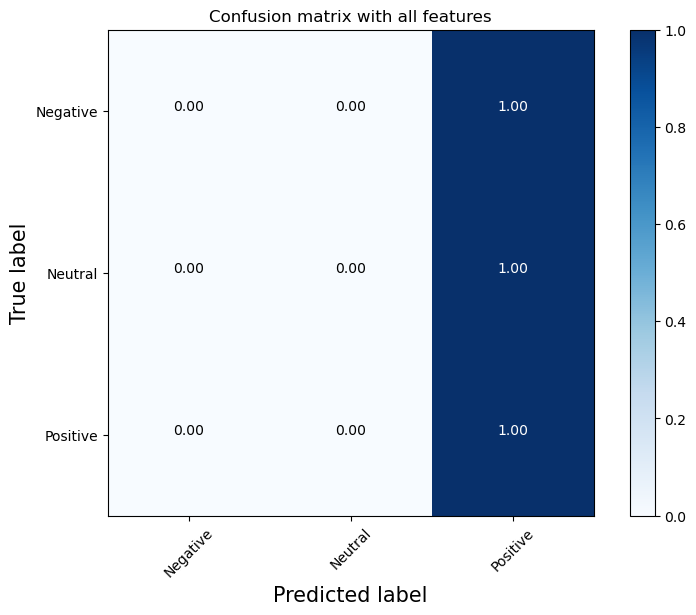

In [35]:
from sklearn.naive_bayes import MultinomialNB

# Initialize the Naive Bayes model
naive_bayes = MultinomialNB()

# Train the model on the training data
naive_bayes.fit(X_train_textr, y_train)

# Predict sentiment labels for the testing data
y_pred_class = naive_bayes.predict(X_test_textr)

# Obtain predicted probabilities for each class
y_pred_prob = naive_bayes.predict_proba(X_test_textr)

#calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob, multi_class='ovr'))
# Other metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_class))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))

plot_confusion_matrix(cnf_matrix, classes=['Negative','Neutral', 'Positive'],normalize=True,
                      title='Confusion matrix with all features')

#### Gradient Boosting: 

Accuracy:  0.9395085066162571
AUC:  0.8822514245694347
Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.36      0.50        33
     neutral       1.00      0.11      0.20         9
    positive       0.94      0.99      0.97       487

    accuracy                           0.94       529
   macro avg       0.91      0.49      0.56       529
weighted avg       0.94      0.94      0.93       529



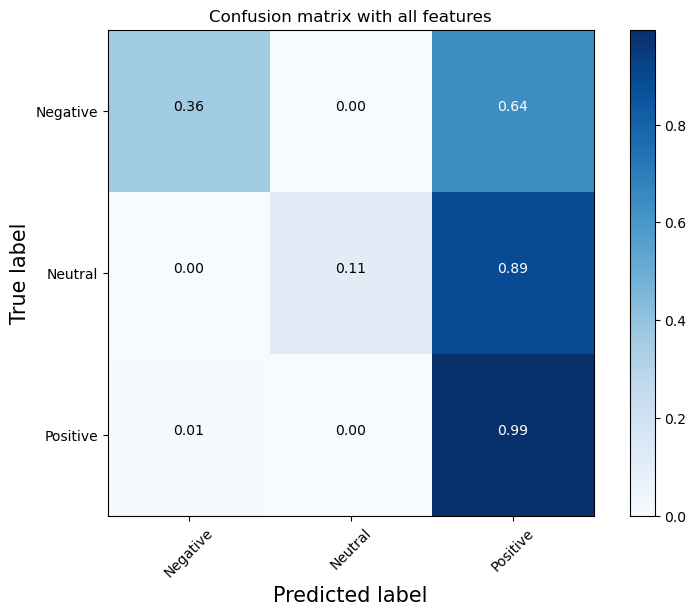

In [36]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Gradient Boosting model
gradient_boosting = GradientBoostingClassifier()

# Train the model on the training data
gradient_boosting.fit(X_train_textr, y_train)

# Predict sentiment labels for the testing data
y_pred_class = gradient_boosting.predict(X_test_textr)

# Obtain predicted probabilities for each class
y_pred_prob = gradient_boosting.predict_proba(X_test_textr)

#calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob, multi_class='ovr'))
# Other metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_class))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))

plot_confusion_matrix(cnf_matrix, classes=['Negative','Neutral', 'Positive'],normalize=True,
                      title='Confusion matrix with all features')



#### Multi-layer Perceptron (MLP):

Accuracy:  0.9395085066162571
AUC:  0.8978622818110796
Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.33      0.47        33
     neutral       1.00      0.11      0.20         9
    positive       0.94      1.00      0.97       487

    accuracy                           0.94       529
   macro avg       0.91      0.48      0.55       529
weighted avg       0.93      0.94      0.92       529



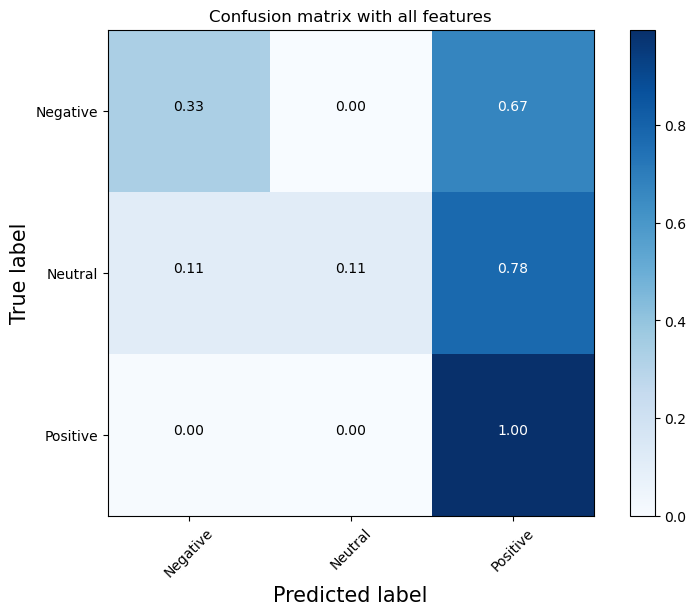

In [37]:
from sklearn.neural_network import MLPClassifier

# Initialize the MLP model
mlp_model = MLPClassifier()

# Train the model on the training data
mlp_model.fit(X_train_textr, y_train)

# Predict sentiment labels for the testing data
y_pred_class = mlp_model.predict(X_test_textr)

# Obtain predicted probabilities for each class
y_pred_prob = mlp_model.predict_proba(X_test_textr)

#calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob, multi_class='ovr'))
# Other metrics
print("Classification Report:")
print(classification_report(y_test, y_pred_class))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))

plot_confusion_matrix(cnf_matrix, classes=['Negative','Neutral', 'Positive'],normalize=True,
                      title='Confusion matrix with all features')

In [38]:
# Testing the models with some texts
print("TESTING")

# Test texts
test_texts = [
    "This product is amazing!",
    "It is not bad",
    "I hate this product, it's terrible",
    " xxxx", 
    "This product is great!",
    "so so",
    "This product is not bad, but it could be better"
]

# Preprocess the test texts
preprocessed_test_texts = [preprocess_text(text) for text in test_texts]

# Vectorize the test texts using the same TF-IDF vectorizer
X_test_vectorized = tfidf_vectorizer.transform(preprocessed_test_texts)

# Test Logistic Regression model
print("Logistic Regression Model:")
# Make predictions
y_pred_logreg = logreg.predict(X_test_vectorized)
print("Predictions:", y_pred_logreg)

# Test SVM model
print("\nSVM Model:")
# Make predictions
y_pred_svm = svm.predict(X_test_vectorized)
print("Predictions:", y_pred_svm)

# Test Naive Bayes model
print("\nNaive Bayes Model:")
# Make predictions
y_pred_naive_bayes = naive_bayes.predict(X_test_vectorized)
print("Predictions:", y_pred_naive_bayes)

# Test Gradient Boosting model
print("\nGradient Boosting Model:")
# Make predictions
y_pred_gradient_boosting = gradient_boosting.predict(X_test_vectorized)
print("Predictions:", y_pred_gradient_boosting)

# Test MLP model
print("\nMLP Model:")
# Make predictions
y_pred_mlp = mlp_model.predict(X_test_vectorized)
print("Predictions:", y_pred_mlp)



TESTING
Logistic Regression Model:
Predictions: ['positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'neutral']

SVM Model:
Predictions: ['positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive']

Naive Bayes Model:
Predictions: ['positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive']

Gradient Boosting Model:
Predictions: ['positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive']

MLP Model:
Predictions: ['positive' 'positive' 'positive' 'positive' 'positive' 'positive'
 'positive']
